In [2]:
import os, glob, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import holidays

In [3]:
# Rough DC geofence
DC_LAT_MIN, DC_LAT_MAX = 38.78, 39.03
DC_LON_MIN, DC_LON_MAX = -77.12, -76.90

combined = pd.read_csv('../CleanData/parking_violations_cleaned_datetime.csv')

combined["issue_datetime"] = pd.to_datetime(combined["ISSUE_DATETIME_UTC"], utc=True).dt.tz_convert(None)

/var/folders/_v/kcxy22753vjfn9jc355xsgs00000gn/T/ipykernel_20140/4134107074.py:5: DtypeWarning: Columns (2,3,12,25,36) have mixed types. Specify dtype option on import or set low_memory=False.
  combined = pd.read_csv('../CleanData/parking_violations_cleaned_datetime.csv')


In [4]:
def pick_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

lat_col = pick_col(combined, ["LATITUDE","latitude","Y","YCOORD","ycoord"])
lon_col = pick_col(combined, ["LONGITUDE","longitude","X","XCOORD","xcoord"])

if lat_col is None or lon_col is None:
    raise ValueError("No latitude/longitude columns were found in the data.")

combined["latitude"]  = pd.to_numeric(combined[lat_col], errors="coerce")
combined["longitude"] = pd.to_numeric(combined[lon_col], errors="coerce")

# drop bad datetimes/coords, then geofence to DC
before = len(combined)
combined = combined.dropna(subset=["issue_datetime","latitude","longitude"]).copy()
combined = combined[
    combined["latitude"].between(DC_LAT_MIN, DC_LAT_MAX) &
    combined["longitude"].between(DC_LON_MIN, DC_LON_MAX)
].copy()
print(f"Kept {len(combined):,} / {before:,} rows after datetime+coord+geofence")

# time features
s = pd.to_datetime(combined["issue_datetime"])
combined["date"]        = s.dt.normalize()
combined["year"]        = s.dt.year.astype("Int16")
combined["month"]       = s.dt.month.astype("Int8")
combined["day_of_week"] = s.dt.dayofweek.astype("Int8")
combined["hour"]        = s.dt.hour.astype("Int8")
combined["is_weekend"]  = combined["day_of_week"].isin([5,6]).astype("Int8")

# holiday flag
try:
    import holidays
    yrs = sorted(combined["year"].dropna().unique().astype(int).tolist())
    hol = holidays.US(years=yrs)
    hol_idx = pd.to_datetime(list(hol.keys()))
    combined["is_holiday"] = combined["date"].isin(hol_idx).astype("Int8")
except Exception:
    combined["is_holiday"] = 0

# month coverage (make sure September 2023 exists)
cov = combined["issue_datetime"].dt.to_period("M").value_counts().sort_index()
print("\nMonthly coverage:")
print(cov.to_string())

print("\nContains 2023-09? ->", any(cov.index.astype(str) == "2023-09"))

Kept 3,081,222 / 3,147,613 rows after datetime+coord+geofence

Monthly coverage:
issue_datetime
2022-12     96584
2023-01    110525
2023-02    104432
2023-03    132464
2023-04    110209
2023-05    116929
2023-06    108189
2023-07    105205
2023-08    113811
2023-09    107321
2023-10    111797
2023-11     87510
2023-12     87596
2024-01     83786
2024-02     86884
2024-03    104651
2024-04    109859
2024-05    112779
2024-06     96394
2024-07    103824
2024-08    104776
2024-09     97559
2024-10    108827
2024-11     82473
2024-12     72652
2025-01     62813
2025-02     73512
2025-03     99851
2025-04    104298
2025-05     95526
2025-06     88186
Freq: M

Contains 2023-09? -> True


In [5]:
# drop cols w >50% nulls
null_pct = combined.isna().mean()
drop_cols = null_pct[null_pct > 0.5].index.tolist()
combined = combined.drop(columns=drop_cols)
print(f"Dropped {len(drop_cols)} cols with >50% nulls: {drop_cols}")

Dropped 4 cols with >50% nulls: ['DISPOSITION_DATE', 'VEHICLE_TYPE', 'DISPOSITION_DESC', 'VIOLATION_TYPE_DESC']


In [6]:
print("NaT count in issue_datetime:", combined["issue_datetime"].isna().sum())
print(combined[["ISSUE_DATE","ISSUE_TIME","issue_datetime","date","year","month","day_of_week","hour","is_weekend","is_holiday"]].head())

# Clean object + string cols 
for col in combined.select_dtypes(include=["object"]).columns:
    combined[col] = combined[col].astype(str).str.strip().replace({"nan": np.nan})

combined

NaT count in issue_datetime: 0
                ISSUE_DATE ISSUE_TIME      issue_datetime       date  year  \
30  2025/06/17 04:00:00+00       1228 2025-06-17 12:28:00 2025-06-17  2025   
32  2025/06/20 04:00:00+00       2338 2025-06-20 23:38:00 2025-06-20  2025   
33  2025/06/20 04:00:00+00       2354 2025-06-20 23:54:00 2025-06-20  2025   
34  2025/06/04 04:00:00+00        745 2025-06-04 07:45:00 2025-06-04  2025   
35  2025/06/04 04:00:00+00        745 2025-06-04 07:45:00 2025-06-04  2025   

    month  day_of_week  hour  is_weekend  is_holiday  
30      6            1    12           0           0  
32      6            4    23           0           0  
33      6            4    23           0           0  
34      6            2     7           0           0  
35      6            2     7           0           0  


,OBJECTID,TICKET_NUMBER,ISSUE_DATE,ISSUE_TIME,ISSUING_AGENCY_CODE,ISSUING_AGENCY_NAME,ISSUING_AGENCY_SHORT,VIOLATION_CODE,LOCATION,PLATE_STATE,...,issue_datetime,latitude,longitude,date,year,month,day_of_week,hour,is_weekend,is_holiday
30,84395696,275257905,2025/06/17 04:00:00+00,1228,50,FEDERAL PROTECTIVE SERVICES (US GV),FPS,P055,SIDE 1201 CONSTITUTION AVE NW,,...,2025-06-17 12:28:00,38.893,-77.029,2025-06-17,2025,6,1,12,0,0
32,84395698,275697181,2025/06/20 04:00:00+00,2338,4,METROPOLITAN POLICE DPT-DISTRICT 4,MPD-4D,P170,600 BLK OTIS PL NW,,...,2025-06-20 23:38:00,38.935,-77.020,2025-06-20,2025,6,4,23,0,0
33,84395699,275697203,2025/06/20 04:00:00+00,2354,4,METROPOLITAN POLICE DPT-DISTRICT 4,MPD-4D,P170,600 BLK OTIS PL NW,,...,2025-06-20 23:54:00,38.935,-77.020,2025-06-20,2025,6,4,23,0,0
34,84395717,276503242,2025/06/04 04:00:00+00,745,50,FEDERAL PROTECTIVE SERVICES (US GV),FPS,P269,NS 600 BLK MARYLAND AVE SW,,...,2025-06-04 07:45:00,38.887,-77.021,2025-06-04,2025,6,2,7,0,0
35,84395718,276503253,2025/06/04 04:00:00+00,745,50,FEDERAL PROTECTIVE SERVICES (US GV),FPS,P168,NS 600 BLK MARYLAND AVE SW,,...,2025-06-04 07:45:00,38.887,-77.021,2025-06-04,2025,6,2,7,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3147608,83587778,8271938231,2024/09/30 04:00:00+00,1535,15,DEPARTMENT OF PUBLIC WORKS,DPW,P012,400 BLOCK NEW JERSEY AVE SE SOU*,,...,2024-09-30 15:35:00,38.885,-77.007,2024-09-30,2024,9,0,15,0,0
3147609,83587779,8271938242,2024/09/30 04:00:00+00,1638,15,DEPARTMENT OF PUBLIC WORKS,DPW,P259,400 BLOCK NORTH CAROLINA AVE SE*,,...,2024-09-30 16:38:00,38.886,-77.000,2024-09-30,2024,9,0,16,0,0
3147610,83587780,8271938253,2024/09/30 04:00:00+00,1639,15,DEPARTMENT OF PUBLIC WORKS,DPW,P170,400 BLOCK NORTH CAROLINA AVE SE*,,...,2024-09-30 16:39:00,38.886,-77.000,2024-09-30,2024,9,0,16,0,0
3147611,83587781,8271938264,2024/09/30 04:00:00+00,1640,15,DEPARTMENT OF PUBLIC WORKS,DPW,P259,400 BLOCK NORTH CAROLINA AVE SE*,,...,2024-09-30 16:40:00,38.886,-77.000,2024-09-30,2024,9,0,16,0,0


In [7]:
out_dir = "../CleanData"
os.makedirs(out_dir, exist_ok=True)

# rows with missing parsed datetime
mask_bad = combined["issue_datetime"].isna()

bad_ts  = combined.loc[mask_bad].copy()
good_ts = combined.loc[~mask_bad].copy()

bad_ts["missing_issue_date"] = combined.loc[mask_bad, "ISSUE_DATE"].isna()
bad_ts["missing_issue_time"] = combined.loc[mask_bad, "ISSUE_TIME"].isna()
bad_ts["raw_issue_date"]     = combined.loc[mask_bad, "ISSUE_DATE"].astype(str)
bad_ts["raw_issue_time"]     = combined.loc[mask_bad, "ISSUE_TIME"].astype(str)

print(f"Kept rows (valid issue_datetime): {len(good_ts):,}")
print(f"Rejected rows (NaT issue_datetime): {len(bad_ts):,} "
      f"({len(bad_ts)/(len(good_ts)+len(bad_ts)):.2%})")


bad_csv  = os.path.join(out_dir, f"dc_parking_bad_timestamps.csv")

bad_ts.to_csv(bad_csv, index=False, compression="gzip")

print("Saved:")
print("  ", bad_csv)

Kept rows (valid issue_datetime): 3,081,222
Rejected rows (NaT issue_datetime): 0 (0.00%)
Saved:
   ../CleanData/dc_parking_bad_timestamps.csv


In [8]:
loc_cols = ["LATITUDE", "LONGITUDE", "XCOORD", "YCOORD"]

missing_loc = good_ts[loc_cols].isna().any(axis=1).sum()
total_rows = len(good_ts)

print(f"Rows missing at least one location value: {missing_loc:,} ({missing_loc/total_rows:.2%})")
print(f"Rows with complete location info: {total_rows - missing_loc:,} ({(total_rows - missing_loc)/total_rows:.2%})")


Rows missing at least one location value: 0 (0.00%)
Rows with complete location info: 3,081,222 (100.00%)


In [9]:
cleaned_df = good_ts.copy()

Date range after cleaning: 2022-12-01 00:00:00 → 2025-06-30 21:22:00
Missing hourly bins: 850 / 22,630 (3.76%)
Missing full days: 0
Missing whole months: 0


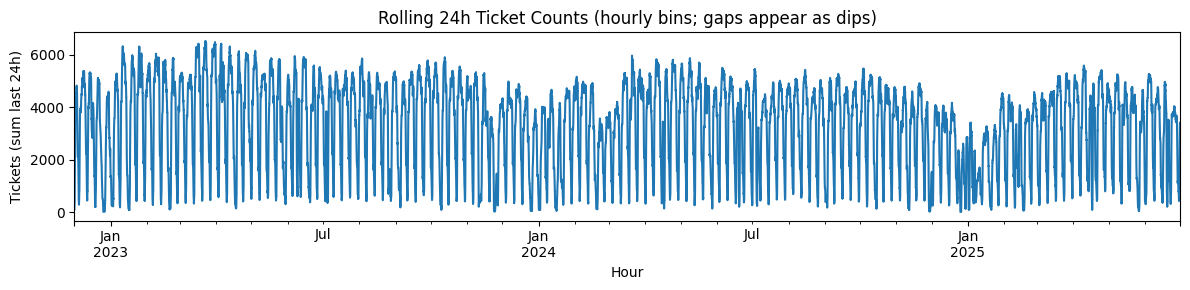

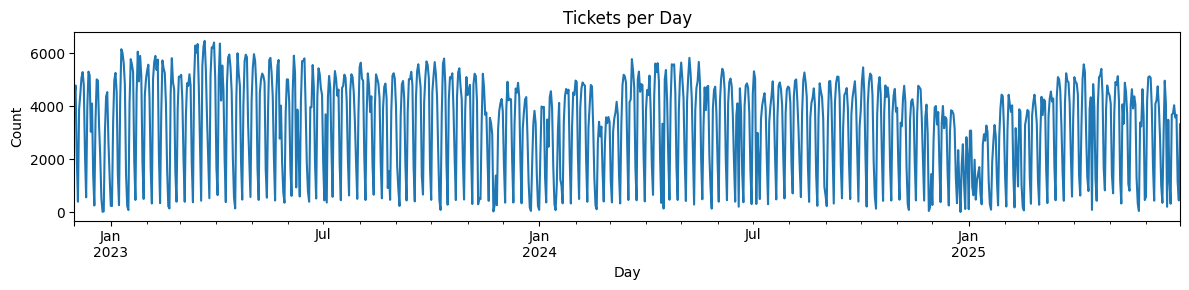

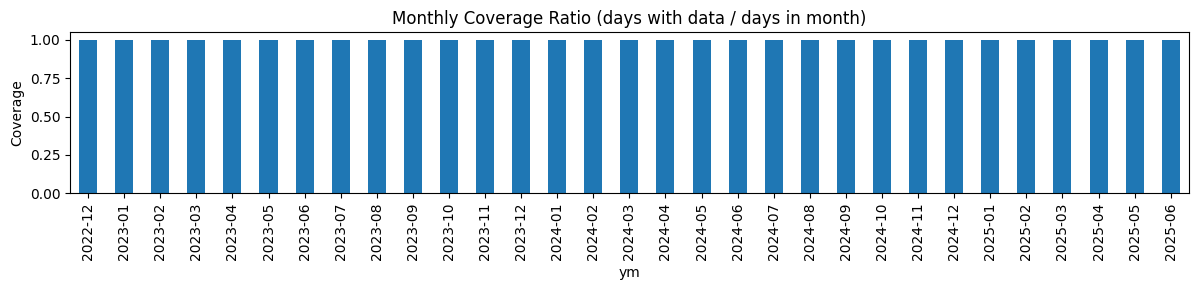

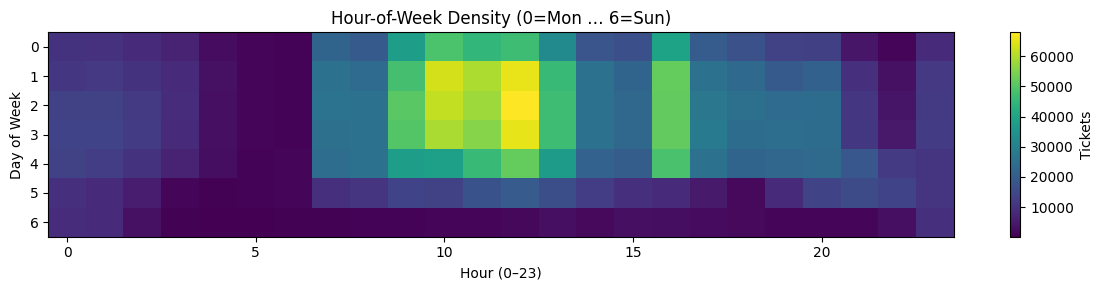

In [10]:
# clean datetime series 
dt = pd.to_datetime(cleaned_df["issue_datetime"], errors="coerce", utc=True)
try:
    dt = dt.dt.tz_convert(None)  # drop tz if present
except Exception:
    pass
dt = dt.dropna()
if dt.empty:
    raise ValueError("No valid issue_datetime values after cleaning.")

min_ts, max_ts = dt.min(), dt.max()
print(f"Date range after cleaning: {min_ts} → {max_ts}")

# hourly coverage
hour_bins = dt.dt.floor("h")
hour_counts = hour_bins.value_counts().rename("n").to_frame()
hour_counts.index.name = "hour_bin"
hour_counts = hour_counts.sort_index()

exp_hours = pd.date_range(hour_counts.index.min(), hour_counts.index.max(), freq="h")
hour_cov = hour_counts.reindex(exp_hours)
n_missing_hours = hour_cov["n"].isna().sum()
pct_missing_hours = n_missing_hours / len(hour_cov) * 100
print(f"Missing hourly bins: {n_missing_hours:,} / {len(hour_cov):,} ({pct_missing_hours:.2f}%)")

# daily coverage 
day_bins = dt.dt.floor("D")
exp_days = pd.date_range(day_bins.min(), day_bins.max(), freq="D")
obs_days = pd.Index(day_bins.unique()).sort_values()   # DatetimeArray → Index → sortable
missing_days = exp_days.difference(obs_days)
print(f"Missing full days: {len(missing_days):,}")
if len(missing_days) > 0:
    print("First few missing days:", list(missing_days[:10]))


# Daily counts
daily_counts = day_bins.value_counts().rename("n").to_frame()
daily_counts.index.name = "date"
daily_counts = daily_counts.sort_index()

# Group by month + coverage
daily_counts["ym"] = daily_counts.index.to_period("M")
coverage = (
    daily_counts
    .groupby("ym", as_index=False)
    .agg(days_with_data=("n", "size"))
)

coverage["days_in_month"] = coverage["ym"].dt.days_in_month
coverage["coverage_ratio"] = coverage["days_with_data"] / coverage["days_in_month"]

# Build full month index between min and max, mark zeros for missing months
exp_months = pd.period_range(daily_counts.index.min(), daily_counts.index.max(), freq="M")
cov_full = pd.DataFrame({"ym": exp_months})
cov_full = cov_full.merge(coverage, on="ym", how="left")
cov_full["days_with_data"] = cov_full["days_with_data"].fillna(0).astype(int)
cov_full["days_in_month"]  = cov_full["ym"].dt.days_in_month
cov_full["coverage_ratio"] = cov_full["coverage_ratio"].fillna(0.0)

missing_months = cov_full.loc[cov_full["coverage_ratio"] == 0, "ym"]
print(f"Missing whole months: {len(missing_months)}")
if len(missing_months) > 0:
    print("Missing months:", ", ".join(str(p) for p in missing_months[:12]),
          ("..." if len(missing_months) > 12 else ""))

# coverage visuals
plt.figure(figsize=(12,3))
hour_cov["n"].fillna(0).rolling(24, min_periods=1).sum().plot()
plt.title("Rolling 24h Ticket Counts (hourly bins; gaps appear as dips)")
plt.xlabel("Hour")
plt.ylabel("Tickets (sum last 24h)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,3))
(daily_counts["n"]).plot()
plt.title("Tickets per Day")
plt.xlabel("Day")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,3))
cov_plot = cov_full.copy()
cov_plot.index = cov_plot["ym"].astype(str)
cov_plot["coverage_ratio"].plot(kind="bar")
plt.xticks(rotation=90)
plt.title("Monthly Coverage Ratio (days with data / days in month)")
plt.ylabel("Coverage")
plt.tight_layout()
plt.show()

tmp = pd.DataFrame({"dow": hour_bins.dt.dayofweek, "hour": hour_bins.dt.hour})
heat = tmp.value_counts().rename("n").reset_index().pivot(index="dow", columns="hour", values="n").fillna(0)
plt.figure(figsize=(12,3))
plt.imshow(heat, aspect="auto", interpolation="nearest")
plt.title("Hour-of-Week Density (0=Mon … 6=Sun)")
plt.xlabel("Hour (0–23)")
plt.ylabel("Day of Week")
plt.colorbar(label="Tickets")
plt.tight_layout()
plt.show()


In [11]:
cleaned_df.head()

,OBJECTID,TICKET_NUMBER,ISSUE_DATE,ISSUE_TIME,ISSUING_AGENCY_CODE,ISSUING_AGENCY_NAME,ISSUING_AGENCY_SHORT,VIOLATION_CODE,LOCATION,PLATE_STATE,...,issue_datetime,latitude,longitude,date,year,month,day_of_week,hour,is_weekend,is_holiday
30,84395696,275257905,2025/06/17 04:00:00+00,1228,50,FEDERAL PROTECTIVE SERVICES (US GV),FPS,P055,SIDE 1201 CONSTITUTION AVE NW,,...,2025-06-17 12:28:00,38.893,-77.029,2025-06-17,2025,6,1,12,0,0
32,84395698,275697181,2025/06/20 04:00:00+00,2338,4,METROPOLITAN POLICE DPT-DISTRICT 4,MPD-4D,P170,600 BLK OTIS PL NW,,...,2025-06-20 23:38:00,38.935,-77.020,2025-06-20,2025,6,4,23,0,0
33,84395699,275697203,2025/06/20 04:00:00+00,2354,4,METROPOLITAN POLICE DPT-DISTRICT 4,MPD-4D,P170,600 BLK OTIS PL NW,,...,2025-06-20 23:54:00,38.935,-77.020,2025-06-20,2025,6,4,23,0,0
34,84395717,276503242,2025/06/04 04:00:00+00,745,50,FEDERAL PROTECTIVE SERVICES (US GV),FPS,P269,NS 600 BLK MARYLAND AVE SW,,...,2025-06-04 07:45:00,38.887,-77.021,2025-06-04,2025,6,2,7,0,0
35,84395718,276503253,2025/06/04 04:00:00+00,745,50,FEDERAL PROTECTIVE SERVICES (US GV),FPS,P168,NS 600 BLK MARYLAND AVE SW,,...,2025-06-04 07:45:00,38.887,-77.021,2025-06-04,2025,6,2,7,0,0


In [12]:
keep_cols = [
    "issue_datetime", "date", "year", "month", "day_of_week", "hour",
    "is_weekend", "is_holiday",
    "LATITUDE", "LONGITUDE",
    "VIOLATION_CODE", "VIOLATION_PROC_DESC",
    "PLATE_STATE",
    "DISPOSITION_TYPE",
    "FINE_AMOUNT"
]

keep_df = cleaned_df[keep_cols].copy()

print("Original shape:", cleaned_df.shape)
print("Lean shape:", keep_df.shape)
keep_df.head()


Original shape: (3081222, 43)
Lean shape: (3081222, 15)


,issue_datetime,date,year,month,day_of_week,hour,is_weekend,is_holiday,LATITUDE,LONGITUDE,VIOLATION_CODE,VIOLATION_PROC_DESC,PLATE_STATE,DISPOSITION_TYPE,FINE_AMOUNT
30,2025-06-17 12:28:00,2025-06-17,2025,6,1,12,0,0,38.893,-77.029,P055,NO PARKING ANYTIME,,Dismissed,30.0
32,2025-06-20 23:38:00,2025-06-20,2025,6,4,23,0,0,38.935,-77.020,P170,FAILURE TO DISPLAY CURRENT TAGS,,Other,100.0
33,2025-06-20 23:54:00,2025-06-20,2025,6,4,23,0,0,38.935,-77.020,P170,FAILURE TO DISPLAY CURRENT TAGS,,Other,100.0
34,2025-06-04 07:45:00,2025-06-04,2025,6,2,7,0,0,38.887,-77.021,P269,NO STANDING ANYTIME,,Other,50.0
35,2025-06-04 07:45:00,2025-06-04,2025,6,2,7,0,0,38.887,-77.021,P168,NO FRONT TAGS.,,Other,50.0


In [13]:
keep_df.describe()

,issue_datetime,date,year,month,day_of_week,hour,is_weekend,is_holiday,LATITUDE,LONGITUDE,FINE_AMOUNT
count,3081222,3081222,3081222.0,3081222.0,3081222.0,3081222.0,3081222.0,3081222.0,3.081222e+06,3.081222e+06,3.081221e+06
mean,2024-02-24 12:51:08.805363712,2024-02-24 00:01:18.710588416,2023.686822,6.066354,2.363487,12.352605,0.093045,0.001634,3.890636e+01,-7.702449e+01,5.957160e+01
min,2022-12-01 00:00:00,2022-12-01 00:00:00,2022.0,1.0,0.0,0.0,0.0,0.0,3.881400e+01,-7.711400e+01,0.000000e+00
25%,2023-06-29 01:20:00,2023-06-29 00:00:00,2023.0,3.0,1.0,9.0,0.0,0.0,3.889500e+01,-7.704100e+01,3.000000e+01
50%,2024-02-21 13:20:00,2024-02-21 00:00:00,2024.0,6.0,2.0,12.0,0.0,0.0,3.890500e+01,-7.702800e+01,5.000000e+01
75%,2024-10-04 17:41:00,2024-10-04 00:00:00,2024.0,9.0,4.0,16.0,0.0,0.0,3.891700e+01,-7.700900e+01,1.000000e+02
max,2025-06-30 21:22:00,2025-06-30 00:00:00,2025.0,12.0,6.0,23.0,1.0,1.0,3.899500e+01,-7.691000e+01,5.000000e+03
std,NaN,NaN,0.786152,3.382826,1.579946,5.286226,0.290495,0.040391,2.148825e-02,2.669845e-02,4.555614e+01


In [14]:
keep_df.columns

Index(['issue_datetime', 'date', 'year', 'month', 'day_of_week', 'hour',
       'is_weekend', 'is_holiday', 'LATITUDE', 'LONGITUDE', 'VIOLATION_CODE',
       'VIOLATION_PROC_DESC', 'PLATE_STATE', 'DISPOSITION_TYPE',
       'FINE_AMOUNT'],
      dtype='object')

In [15]:
len(keep_df)

3081222

In [16]:
keep_df.to_csv("../CleanData/prepared_data.csv", index=False)